# Project AirBnB Berlin Exploration 

This project predict a good place to life in Berlin. One hint for this prediction can be found in the AirBnB data base. This project was completed as the part "Write a Data Science Blog Post" of the course requirements of Udacity's [Data Scientist Nanodegree](https://www.udacity.com/course/data-scientist-nanodegree--nd025) certification. 


## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#business">Business Understanding - Problem Statement</a></li>
    <li><a href="#Gather">Gather</a></li>
    <li><a href="#GetData">Get the data</a>
    <li><a href="#DataUnder">Data Understanding</a>
    <ol type="1">
        <li><a href="#calendar">Calendar</a></li>
        <li><a href="#listings">Listings</a></li>
        <li><a href="#reviews">Reviews</a></li>
        <li><a href="#listsum">Listings Summary</a></li>
        <li><a href="#nbhoods">Neighbourhood</a></li> 
        <li><a href="#nbhgeos">Neighbourhood GeoInformation</a></li> 
    </ol></li>
    <li><a href="#DataPrep">Data Preparation</a>
    <ol type="1">
        <li><a href="#clean">Cleaning</a>
        <li><a href="#engineer">Feature Engineering</a>
    </ol></li>
    <li><a href="#Model">Modeling</a>
    <ol type="1">
        <li><a href="#ModelRevenue">Build models to predict listing revenues</a></li>
        <li><a href="#ModelRecommend">Recommend what we normally want</a></li>
        <li><a href="#ModelEncodeRFCPCA">Encode it and enjoy Random Forest Classifier</a></li> 
        <li><a href="#ModelTime">Time trends</a></li> 
    </ol></li>
    <li><a href="#Eval">Evaluation, design and show the results</a>
    <ol type="1">
        <li><a href="#EvalData">Nice Data in the Neighbourhood</a></li>
        <li><a href="#EvalGoogle">A picture can help</a></li>
        <li><a href="#EvalConclusion">Conclusion</a></li>
    </ol></li>
    <li><a href="#Deploy">Deployment</a>
</ol>

<a id='intro'></a>
## 1. Introduction

The data explored in this notebook was obtained from the [InSide Airbnb Open Data](http://insideairbnb.com/get-the-data.html). The data contains information about the availability of the listings, the characteristics of the listing and host, and reviews provided by guests staying at the listing thru September 2019.

It will be explored implementing the Cross-Industry Standard Process for Data Mining (CRISP-DM) process as part of the Write a Data Science Blog Post project requirements for Udacity's Data Scientist Nanodegree. The CRISP-DM process encompasses six elements:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The data will be gathered and initial exploration completed to enable the first two elements to be completed. Deployment will take the form of a blog post targeted at a general audience, informing them of the action items.

<a id='business'></a>
## 2. Problem Statement - Business Understanding

To save time, I am looking for an apartment in Berlin for my daughter. One great idea is to rummage through data from AirBnB. Let's see what comes out ...

For this analysis I will answer the following 4 questions:

1. What is the booking load?
2. How is the district scoring?
3. What are the revenues of the district?
4. Show me the best place to live

Since September 2019, there are about 24,000 Airbnb entries in the twelve Berlin districts. I assume that I will limit my search to one or two parts of the city. My analysis is based on the assumption that I can draw a conclusion on my questions from the room prices, the rating and the booking behavior. **I ask a machine learning algorithm to find patterns in the data and group similar entries in clusters**

<a id='Gather'></a>
## 3. Gather 

First, let's read the  necessary libraries and set initial value.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import math, random, time, locale
from collections import Counter
from typing import List
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas 
import geopandas as gpd
import json
# for vizualizing with bokeh and google 
from bokeh.io import curdoc
from bokeh.models import StaticLayoutProvider, Circle
from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.models import GMapPlot, GMapOptions, ColumnDataSource, Circle, Range1d, BasicTicker,\
ColorBar, PanTool, WheelZoomTool, BoxSelectTool, LabelSet, HoverTool, TapTool, Patches, DataRange1d, \
BoxZoomTool, renderers, GraphRenderer, GeoJSONDataSource, StaticLayoutProvider, Circle
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import inferno, magma, cividis, Spectral4, brewer
from bokeh.plotting import figure
from bokeh.layouts import row
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.core.validation import silence
from shapely.geometry import Point

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column


silence(EMPTY_LAYOUT, True)
silence(MISSING_RENDERERS, True)
%matplotlib inline
# Notebook options
pd.options.display.max_rows = 99999
pd.options.display.max_columns = 99999
pd.options.display.float_format = '{:20,.3f}'.format

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)



In [2]:
!python --version

Python 3.7.3


<a id='GetData'></a>
## 4. Get the data

In this first section of the notebook we will get the data which will be used for the analysis. The data comes from CSV sources. Lets look at each one of these more closely to see which one we will use for our analysis.

[Tom Slee](https://github.com/tomslee/airbnb-data-collection) has developed a very good method with the **Airbnb web site scraper**. This allows direct access to the current AirBnB data. Unfortunately, I could not persuade the scraper to run in my environment. Therefore, I decided to load the data directly to my computer.

At first I look which data are avialable:

- **listings.csv**			Detailed Listings data for Berlin City
- **calendar.csv**			Detailed Calendar Data for listings in Berlin City
- **reviews.csv**				Detailed Review Data for listings in Berlin City
- **neighbourhoods.csv**		Neighbourhood list for geo filter. Sourced from city or open source GIS files.
- **listings_summary.csv**	Summary information and metrics for listings in Berlin City (good for visualisations).
- **reviews_summary.csv**		Summary Review data and Listing ID (to facilitate time based analytics and visualisations linked to a listing).
- **neighbourhoods.geojson**	GeoJSON file of neighbourhoods of the city.

The main information for my predidiciton I'll see in the first 4 files.

In [3]:
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
listsum = pd.read_csv('./data/listings_summary.csv')
reviews = pd.read_csv('./data/reviews.csv')
nbhoods = pd.read_csv('./data/neighbourhoods.csv')
nbhgeos = geopandas.read_file('./data/neighbourhoods.geojson')

<a id='DataUnder'></a>
## 5. Data Understanding

In order to get a better understanding of the data I'll looking closer, let's take a look at some of the characteristics of the dataset.

In [4]:
def summary(data):
    """ 
    Give a summary of the dataset
   
    Input:
    data (DF): DataFrame

    Returns:
    Print statement with data shape and percentage
    """
    data.info(verbose=True)
    print('\n')
    print((data.isnull().sum()[data.isnull().sum()>0]/data.shape[0])*100)
    print('\n')  
    print("no missing values")
    print(set(data.columns[data.isnull().mean()==0])) #Provide a set of columns with 0 missing values.
    print('\n')
    print("most missing values")
    print(set(data.columns[data.isnull().mean() > 0.75])) #Provide a set of columns with more than 75% of the values missing  

<a id='Data'></a>
## 5.1. Calender

The dataset contains info on the availability lists per id by date, including if the id was available and the listing price.

In [5]:
summary(calendar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914030 entries, 0 to 8914029
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 476.1+ MB


price                           0.002
adjusted_price                  0.002
dtype: float64


no missing values
{'date', 'available', 'minimum_nights', 'maximum_nights', 'listing_id'}


most missing values
set()


In [6]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,38570229,2019-09-19,t,$130.00,$130.00,1,1125
1,38570229,2019-09-20,t,$142.00,$142.00,1,1125
2,38570229,2019-09-21,t,$158.00,$158.00,1,1125
3,38570229,2019-09-22,t,$129.00,$129.00,1,1125
4,38570229,2019-09-23,f,$129.00,$129.00,1,1125


In [7]:
# not realy intressting ... for a later analyzis 
# calendar.price.value_counts()

In [8]:
calendar.available.value_counts()

f    7094101
t    1819929
Name: available, dtype: int64

The dataset contains 7 columns with almost 8.9 Million rows of data.

#### Data Issues in CALENDAR Identified 
- **listing_id**: <span style="color:green">convert to `str`</span>
- **date**: <span style="color:green"> convert to `datetime`</span>
- **available**: <span style="color:green">convert to dummy</span>
- **price**: <span style="color:green">drop the currency sign and convert to float/int</span>
- **adjusted_price**: <span style="color:green">drop the currency sign and convert to float/int</span>
- **minimum_nights**: <span style="color:green">can be deleted</span>
- **maximum_nights**: <span style="color:green">can be deleted</span>

It appears that while a decimal point is included in the prices, no price actually include cents. Based on what can be viewed above, the lowest price is around 25 Dollar while the highest price ranges close to 900 Dollar. All higher price are could be a mistake, a hotel offer or a flat in Bundestag :-) . 

<a id='listings'></a>
## 5.2. Listings

In [9]:
summary(listings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24422 entries, 0 to 24421
Data columns (total 106 columns):
id                                              int64
listing_url                                     object
scrape_id                                       int64
last_scraped                                    object
name                                            object
summary                                         object
space                                           object
description                                     object
experiences_offered                             object
neighborhood_overview                           object
notes                                           object
transit                                         object
access                                          object
interaction                                     object
house_rules                                     object
thumbnail_url                                   float64
medium_url 

{'accommodates', 'host_url', 'minimum_maximum_nights', 'id', 'latitude', 'longitude', 'calculated_host_listings_count_entire_homes', 'maximum_nights', 'minimum_minimum_nights', 'availability_90', 'number_of_reviews_ltm', 'host_id', 'calculated_host_listings_count', 'experiences_offered', 'maximum_maximum_nights', 'neighbourhood_group_cleansed', 'bed_type', 'picture_url', 'require_guest_phone_verification', 'host_verifications', 'country_code', 'instant_bookable', 'guests_included', 'extra_people', 'calculated_host_listings_count_private_rooms', 'country', 'is_location_exact', 'property_type', 'maximum_nights_avg_ntm', 'maximum_minimum_nights', 'scrape_id', 'calendar_updated', 'has_availability', 'calculated_host_listings_count_shared_rooms', 'room_type', 'minimum_nights_avg_ntm', 'street', 'listing_url', 'is_business_travel_ready', 'smart_location', 'require_guest_profile_picture', 'amenities', 'calendar_last_scraped', 'requires_license', 'price', 'number_of_reviews', 'neighbourhood_cl

In [10]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190919050244,2019-09-19,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,"Please check-in by 10pm, and we can't accept c...",There is ample street parking. We are near 2 ...,"Your room, the bathroom and the kitchen, and o...",I'll be traveling a lot in the summer and not ...,Please do not use the wireless Internet access...,nan,nan,https://a0.muscache.com/im/pictures/107924758/...,nan,2164,https://www.airbnb.com/users/show/2164,Lulah,2008-08-16,"Berlin, Berlin, Germany",I'm an American artist living in Berlin for 24...,a few days or more,0%,nan,f,https://a0.muscache.com/im/users/2164/profile_...,https://a0.muscache.com/im/users/2164/profile_...,Wedding,0.000,0.000,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Berlin, Berlin, Germany",Wedding,Brunnenstr. Nord,Mitte,Berlin,Berlin,13355,Berlin,"Berlin, Germany",DE,Germany,52.544,13.397,t,Apartment,Private room,1,1.000,1.000,1.000,Real Bed,"{""Cable TV"",Internet,Wifi,""Free street parking...",nan,$21.00,$190.00,$550.00,$0.00,$0.00,1,$10.00,120,120,120,120,120,120,120.000,120.000,9 months ago,t,29,59,89,364,2019-09-19,18,1,2013-09-07,2018-11-11,82.000,9.000,8.000,9.000,9.000,9.000,8.000,t,NaN,nan,f,f,moderate,f,f,1,0,1,0,0.250
1,2015,https://www.airbnb.com/rooms/2015,20190919050244,2019-09-19,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",nan,nan,https://a0.muscache.com/im/pictures/260fd609-7...,nan,2217,https://www.airbnb.com/users/show/2217,Ion,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,100%,nan,t,https://a0.muscache.com/im/pictures/21428a22-4...,


Need more detail information about the columns


In [11]:
listings.groupby(['room_type']).agg({'id':'count'})

,id
room_type,
Entire home/apt,12136
Hotel room,348
Private room,11638
Shared room,300


In [12]:
listings.groupby(['property_type']).agg({'id':'count'})

,id
property_type,
Aparthotel,12
Apartment,21657
Barn,4
Bed and breakfast,52
Boat,17
Boutique hotel,88
Bungalow,25
Cabin,8
Camper/RV,10


In [13]:
listings.groupby(['property_type', 'room_type']).agg({'id':'count'})

id
property_type          room_type             
Aparthotel             Hotel room           5
                       Private room         6
                       Shared room          1
Apartment              Entire home/apt  10761
                       Hotel room           1
                       Private room     10702
                       Shared room        193
Barn                   Entire home/apt      1
                       Private room         3
Bed and breakfast      Hotel room           7
                       Private room        42
                       Shared room          3
Boat                   Entire home/apt     16
                       Shared room          1
Boutique hotel         Hotel room          63
                       Private room        25
Bungalow               Entire home/apt     21
                       Private room         4
Cabin                  Entire home/apt      7
                       Shared room          1
Camper/RV              Entire home/apt      7
                       Private room         3
Casa particular (Cuba) Private room         2
Castle                 Entire home/apt      1
                       Private room         2
Cave                   Private room         1
Condominium            Entire home/apt    354
                       Private room       285
                       Shared room         12
Cottage                Entire home/apt      7
                       Private room         1
Earth house            Private room         1
Guest suite            Entire home/apt     39
                       Private room        32
Guesthouse             Entire home/apt     51
                       Private room        10
Hostel                 Hotel room          85
                       Private room        30
                       Shared room         75
Hotel                  Entire home/apt      2
                       Hotel room          76
                       Private room         9
House                  Entire home/apt    221
                       Private room       253
                       Shared room          3
Houseboat              Entire home/apt     16
                       Private room         1
Lighthouse             Private room         1
Loft                   Entire home/apt    379
                       Private room        87
                       Shared room          3
Other                  Entire home/apt      7
                       Private room        26
                       Shared room          1
Pension (South Korea)  Private room         8
Resort                 Private room         2
Serviced apartment     Entire home/apt    192
                       Hotel room         111
                       Private room        10
                       Shared room          2
Tiny house             Entire home/apt      6
                       Private room         6
Tipi                   Private room         1
Townhouse              Entire home/apt     40
                       Private room        76
                       Shared room          1
Treehouse              Private room         3
Vacation home          Entire home/apt      1
Villa                  Entire home/apt      7
                       Private room         6
                       Shared room          4

The dataset contains 106 columns and 24,422 rows of data. It looks as if this provides details for unique listings per row.

#### Data Issues in LISTINGS Identified 

After reviewing the listing data I identified the most useful features for me to answer related questions. The features are the following:

- **id**: Listing id, all unique, helpful for joining. <span style="color:green">Convert to str.</span>
- **zipcode**: Zipcode of listing. <span style="color:green">Attempt to use `street` to extract missing values.</span>
- **review_scores_rating**: Some central measure of all ratings from 0 to 100. <span style="color:orange">May dummy missing.</span>
- **reviews_per_month**: As described. Same amount missing as first/last review. <span style="color:orange">May dummy missing.</span>
- **price**: Price of listing (at time of scrape?) <span style="color:green">Maybe drop because of calendar price.</span>
- **accommodates**: Max number of ppl able to be accommodated.
- **latitude, longitude**: Coordinates for listing
- **property_type**: Selection of property types. <span style="color:orange">Convert to dummies.</span>
- **room_type**: Three levels, entire, private, shared. <span style="color:orange">Convert to dummies.</span>
- **neighbourhood_cleansed**: Provides neighbourhood details for the listing. <span style="color:orange">Maybe convert to dummy.</span>
- **neighbourhood_group_cleansed**: Provides wider grouping of listing location. <span style="color:orange">Maybe convert to dummy.</span>

Follow empty or unnecessary columns can dropped:

- **listing_url**: The url for the listing of the form `https://www.airbnb.com/rooms/id`. 
- **name**: Name selected by host for listing. 
- **neighborhood_overview**: Neighborhood description that looks to be provided by the host. Not always provided. 
- **notes**: Additional information provided by the host. The information provided in this column can be quite variable. 
- **transit**: Description of availability of public transport by host.
- **picture_url**: Always has a picture url. 
- **host_id**: ID for the host, there are definitely hosts with multiple listings. 
- **host_url**: url for host, same number as host_id. 
- **host_name**: Seems just first name is typically used. 
- **host_since**: Date from when the host joined. 
- **host_location**: Info provided by hosts. Typically of city, state, country format, but not consistent. 
- **host_about**: Description provided by host. My contain location and employment/hobbies info. 
- **host_response_time**: Ordinal categorization of response time with four levels. 
- **host_response_rate**: Percentage of whether they respond. 
- **host_acceptance_rate**: Almost empty
- **host_is_superhost**: Binary with 't' and 'f'. 
- **host_neighbourhood**: Seems to represent host location but distinct values. 
- **host_listings_count**: Seems to be number of listings per host. 
- **host_verifications**: List of methods that host has been verified. 
- **host_has_profile_pic**: Binary with 't' and 'f'. 
- **host_identity_verified**: Binary with 't' and 'f'. 
- **street**: Provides street, city, state abbr, zip code and country info for listing. 
- **smart_location**: All equivalent of Berlin?. 
- **is_location_exact**: Binary with 't' and 'f'. 
- **bed_type**: Five levels of bed type. 
- **amenities**: List of available amenities. 
- **security_price**: Value of security deposit, if required.
- **cleaning_fee**: Value of cleaning fee, if required. 
- **guests_included**: Create "max accommodation included in price" 
- **extra_people**: Cost per extra person. 
- **minimum/maximum_nights**: 
- **calendar_update**: String of last time updated 
- **availability_30/60/90/365**: Number of days listed as available in the interval (assuming from scrape date). 
- **number_of_reviews**: Number of reviews received by host.
- **first/last_review**: Date of first/last review, not sure why some missing. 
- **review_scores_accuracy/cleanliness/checkin/location/value**: Some central measure of the rating from 1 (low) to 10 (high) on the characteristic described. 
- **instant_bookable**: Binary with 't' and 'f'. 
- **cancellation_policy**: Three levels. 
- **require_guest_profile_picture/phone_verification**: Binary with 't' and 'f'. 
- **calculated_host_listings_count**: 
- **scrape_id**: The id of the data scrape by airbnb. 
- **last_scraped**: The date of the scrape. 
- **xl_picture_url**: Larger size of above. Most empty. 
- **summary, space, description**: Text descriptions of the property provided by host. It appears that the information found in each of these can overlap. 
- **experiences_offered**: All values are `none`. 
- **thumbnail_url**: Link of the thumbnail image used for the listing. 100% missing.
- **medium_url**: Larger size of above. Same missing 100%. 
- **host_thumbnail_url**: Url of host pic thumbnail.
- **host_picture_url**: Large version of above. 
- **host_total_listings_count**: Seems no different than above. 
- **neighbourhood**: in this case not necassery 
- **city**: All values are the equivalent of Berlin
- **state**: All values are the equivalent of Berlin 
- **market**: not usefull 
- **has_availability**: All have availabilities. 
- **calendar_last_scraped**: not usefull 
- **country_code**: in this case not usefull - its only Berlin
- **country**: in this case not usefull - its only Berlin
- **bathrooms**: Number of bathrooms in listing. 
- **bedrooms**: Number of bedrooms in listing. 
- **beds**: Number of beds in listing. 
- **square_feet**: Size of listing. 100% missing value.
- **weekly_price**: Price per week (if available). 100% missing value
- **monthly_price**: Price per month (if available). 100% missing value
- **requires_license**: not necassery
- **license**: 100% missing value
- **jurisdiction_names**: 100% missing value

<a id='reviews'></a>
## 5.3. Reviews

In [14]:
summary(reviews)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501002 entries, 0 to 501001
Data columns (total 6 columns):
listing_id       501002 non-null int64
id               501002 non-null int64
date             501002 non-null object
reviewer_id      501002 non-null int64
reviewer_name    501002 non-null object
comments         500760 non-null object
dtypes: int64(3), object(3)
memory usage: 22.9+ MB


comments                  0.048
dtype: float64


no missing values
{'date', 'reviewer_name', 'reviewer_id', 'id', 'listing_id'}


most missing values
set()


In [15]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1944,7126992,2013-09-07,8207524,Mirko,I want to thank Laura&Emiliano for their hospi...
1,1944,7428447,2013-09-19,3021574,Rafiee,Very convenient and very quiet. You will stay...
2,1944,8455250,2013-10-31,5875429,Grzegorz,I've spent 2 nights at place of Laura and Emil...
3,1944,11105498,2014-03-20,5361252,Ngọc Thúy,The reservation was canceled 2 days before arr...
4,1944,15920963,2014-07-18,6659444,Nathalie,Laura est très sympathique et l'appartement fa...


The dataset contains six columns and almost 500K rows of data.

#### Data Issues in REVIEWS Identified
- **listing_id, id, reviewer_id**: Data identifier 
- **date**: Date
- **reviewer_name**: Name 
- **comments**: free comments

The only feature with missing values is `comments`. It appears a small amount of people give some kind of review without leaving comments.

My first analysis shows me that this data is not really useful. I will not investigate further.

<a id='listsum'></a>
## 5.4. Listungs Summary

In [16]:
summary(listsum)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24422 entries, 0 to 24421
Data columns (total 16 columns):
id                                24422 non-null int64
name                              24371 non-null object
host_id                           24422 non-null int64
host_name                         24390 non-null object
neighbourhood_group               24422 non-null object
neighbourhood                     24422 non-null object
latitude                          24422 non-null float64
longitude                         24422 non-null float64
room_type                         24422 non-null object
price                             24422 non-null int64
minimum_nights                    24422 non-null int64
number_of_reviews                 24422 non-null int64
last_review                       20286 non-null object
reviews_per_month                 20286 non-null float64
calculated_host_listings_count    24422 non-null int64
availability_365                  24422 non-null int64

The dataset contains 16 columns and almost 24.5K rows of data.

#### Data Issues in LISTINGS_SUMMARY Identified

- **id**: Data identifier. Simular to listing_id <span style="color:green">convert to `str`</span>
- **name**: name of reviewer <span style="color:green">can be dropped`</span>
- **host_id**:  <span style="color:green">can be dropped`</span>
- **host_name**: name of host <span style="color:green">can be dropped`</span>
- **neighbourhood_group**: name of district <span style="color:green">can be dropped`</span>
- **neighbourhood**: <span style="color:green">can be dropped`</span>
- **latitude**: GeoInformation
- **longitude**: GeoInformation
- **room_type**: <span style="color:green">can be dropped`</span>
- **price**: Price per night <span style="color:green">no convertion to float/int</span>
- **minimum_nights**: In this case a summary of nights <span style="color:green">no convertion to float/int</span>
- **number_of_reviews**: a summary of reviews <span style="color:green">no convertion to float/int</span>
- **last_review**: <span style="color:green">can be dropped`</span>
- **reviews_per_month**: <span style="color:green">can be dropped`</span>
- **calculated_host_listings_count**: <span style="color:green">can be dropped`</span>
- **availability_365**: <span style="color:green">can be dropped`</span>

In my further analysis of the reviews, the listing_summary is the most helpful. Here are the  important information in the columns price, minimum_nights and number_of_reviews. This information can be deduced to the revenue.

<a id='nbhoods'></a>
## 5.5 Neighborhouds 

In [17]:
summary(nbhoods)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 2 columns):
neighbourhood_group    138 non-null object
neighbourhood          138 non-null object
dtypes: object(2)
memory usage: 2.2+ KB


neighbourhood_group                  0.719
neighbourhood                        0.719
dtype: float64


no missing values
set()


most missing values
set()


In [18]:
nbhoods.head()

,neighbourhood_group,neighbourhood
0,Charlottenburg-Wilm.,Barstraße
1,Charlottenburg-Wilm.,Charlottenburg Nord
2,Charlottenburg-Wilm.,Düsseldorfer Straße
3,Charlottenburg-Wilm.,Forst Grunewald
4,Charlottenburg-Wilm.,Grunewald


The dataset contains 2 columns and almost 138 rows of data.

#### Data Issues Identified
- **neighbourhood**: Information about street in Berlin 
- **neighbourhood_group**: District

The data neighborhood in connection with the GeoData gives a visual impression of where the best district could be. 

<a id='nbhgeos'></a>
## 5.6 Neighborhouds GeoInformation

In [19]:
type(nbhgeos)

geopandas.geodataframe.GeoDataFrame

In [20]:
len(nbhoods.neighbourhood.unique())

139

In [21]:
nbhoods.neighbourhood_group.value_counts()

Treptow - Köpenick          20
Charlottenburg-Wilm.        17
Pankow                      16
Lichtenberg                 13
Reinickendorf               11
Mitte                       10
Neukölln                    10
Marzahn - Hellersdorf        9
Spandau                      9
Friedrichshain-Kreuzberg     8
Steglitz - Zehlendorf        8
Tempelhof - Schöneberg       7
Name: neighbourhood_group, dtype: int64

In [22]:
nbhgeos.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


<Figure size 432x288 with 0 Axes>

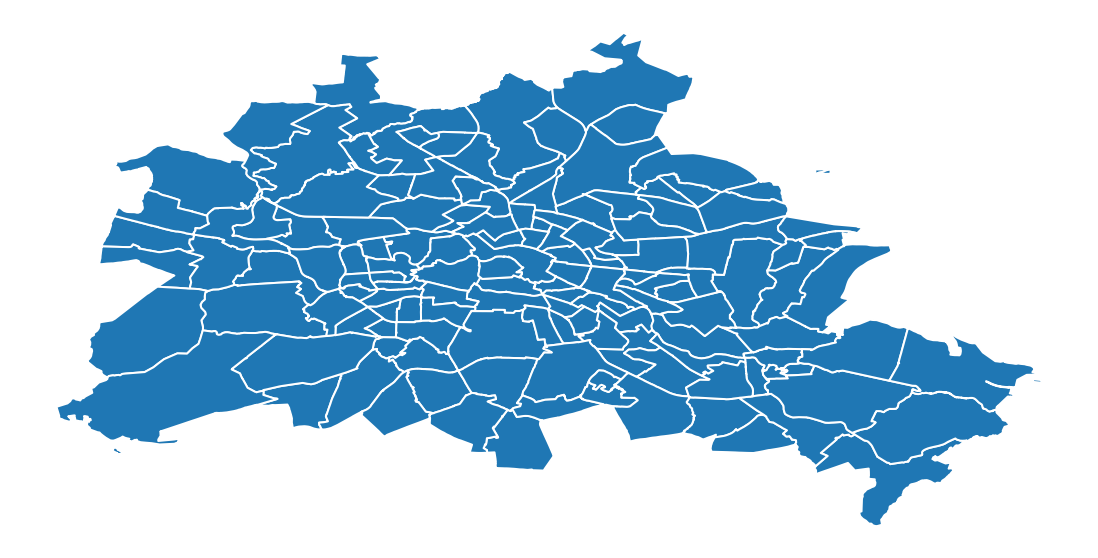

In [23]:
# Show me all about Berlin
plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
nbhgeos.plot(ax=ax, figsize=(20,10))
ax.set_axis_off()
plt.show()
fig.savefig("./figure/berlin_geomap_distrigt_all.jpg", bbox_inches='tight')

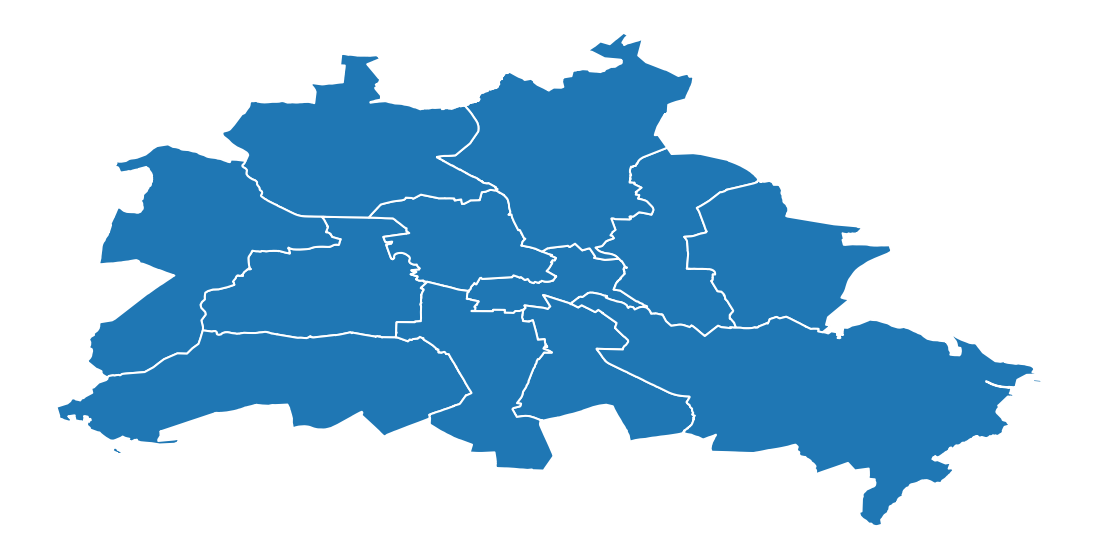

In [24]:
# Show me the districts in Berlin
# Hint: The districts are saved as MULTIPOLYGON. So I dissolved this ..
districts = nbhgeos.dissolve(by='neighbourhood_group')

fig, ax = plt.subplots(figsize=(20,10))
districts.plot(ax=ax, figsize=(20,10))
ax.set_axis_off()
plt.show()
fig.savefig("./figure/berlin_geomap_distrigtgroup.jpg", bbox_inches='tight')

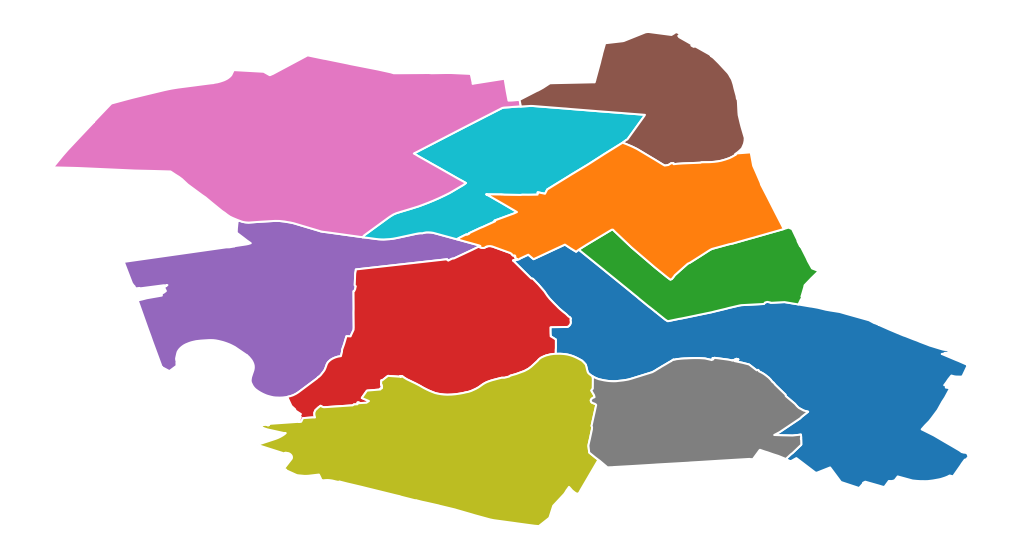

In [25]:
# Show me the famous district Mitte 
fig, ax = plt.subplots(figsize=(20,10))
nbhgeos[nbhgeos.neighbourhood_group == "Mitte"].plot(ax=ax, figsize=(20,10), column='neighbourhood')
ax.set_axis_off()
plt.show()
fig.savefig("./figure/berlin_geomap_mitte.jpg", bbox_inches='tight')

The dataset contains 12 districts and almost 136 neighbourhood.

#### Data Issues Identified
- **none**: I need all data

The geo-information is needed for later visualization of the best districts

<a id='DataPrep'></a>
## 6 Data Preparation


<a id='clean'></a>
## 6.1 Cleaning


let's focus on the main columns and reject all others.

In [26]:
# Columns to keep in listing 
columns_listings = ['id', 
                   'price', 
                   'accommodates', 
                   'property_type', 
                   'room_type', 
                   'neighbourhood_cleansed', 
                   'neighbourhood_group_cleansed', 
                   'review_scores_rating', 
                   'zipcode', 
                   'latitude', 
                   'longitude']

# Colums to keep in calendar
columns_calendar = ['listing_id',
                    'date',
                    'available',
                    'adjusted_price',
                    'minimum_nights',
                    'maximum_nights']

# Columns to keep in listing Summary
columns_listsum = ['id',
                  'host_id',
                  'minimum_nights',
                  'number_of_reviews']

In [27]:
listings.shape

(24422, 106)

In [28]:
# drop all other columns from listings, calendar and listins_summary dataframe and keep only the necassery information
clean_listings = listings[columns_listings].copy()
clean_calendar = calendar[columns_calendar].copy()
clean_listsum = listsum[columns_listsum].copy()

In [29]:
clean_listings.shape

(24422, 11)

In [30]:
clean_calendar.shape

(8914030, 6)

In [31]:
clean_listsum.shape

(24422, 4)

Next, I clean up the listings, calendar listings_summary data refining the columns 

In [32]:
# lets clean data

def clean_df(listings_df):
    """
    Return cleaned datasets with all string variables for price, weekly_price, monthly_price,
    security_deposit, cleaning_fee, extra_people replaced with float variables without the dollar
    sign $. Also replace all string variables for host_response_rate, host_acceptance_rate with
    float variables without the percentage sign %. Lastly convert all dates in listings and calendar
    dataframe with datetime.
    
    INPUTS:
        listings_df - dataframe for listings
    OUTPUTS:
        listings_df - cleaned dataframe for listings. 
    """
    # Convert string of prices to floats
    listings_df.price=listings_df.price.str.replace('$','')
    listings_df.price=listings_df.price.str.replace(',','').astype(float)
    
    return listings_df

In [33]:
# clean the dataframes without listings_summary 
clean_listings = clean_df(clean_listings)

In [34]:
# reduce the calendar to the key figure available and occupancy_rate
def clean_calendar_data(df):
    '''
    INPUT
    df - pandas dataframe containing info from the calendar.csv file

    OUTPUT
    df - aggregrated dataframe containing occupancy rate per day
    '''
    df_calendar = df.copy()
    # Convert string of prices to floats
    df_calendar.adjusted_price=df_calendar.adjusted_price.str.replace('$','')
    df_calendar.adjusted_price=df_calendar.adjusted_price.str.replace(',','').astype(float)

    # Convert date string to datetime
    df_calendar['date'] = pd.to_datetime(df_calendar['date'], format='%Y-%m-%d')

    # Make sure we only take the rows where the appartment was booked, then group by on date and count how many houses were booked
    data_calendar = df_calendar[df_calendar['available'] == 'f'].groupby('date').count()['listing_id'].reset_index()
    # Then divide that number by the total number of houses in the dataset
    data_calendar['listing_id'] = data_calendar['listing_id'] / df_calendar.listing_id.nunique()
    # Rename the columns
    data_calendar.columns = ['date', 'occupancy_rate']
    # Cast the datatype of the date column so that we can use plot_date.
    data_calendar['date'] = pd.to_datetime(data_calendar['date'])

    return data_calendar

In [35]:
# reduce the calendar data with only the 2019 and older data
# clean_calendar = clean_calendar[(clean_calendar.date < '2019-01-01')]

In [36]:
# build the calendar range
clean_calendar = clean_calendar_data(clean_calendar)

Second, for validation purpose, lets first check the float_missing_cols. If the missing value imputation is successful, then we should expect to see these NaN values replaced by their median values.


In [37]:
def replace_missing_values(cols, df):
    '''
        Takes a list of columns and a dataframe and imputes based on
        the column type. If it is object type, then most_frequent value
        is used for imputation. If it is a float/int type, then the median
        value is used for imputation.
        arguments:
            cols: list of columns
            df : dataframe containing these columns.
        returns:
            df: the imputed dataframe
    '''
    for col in cols:
        if type(df[col].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
            print("Imputing {} column with most frequent value".format(col))
            mode_imputer = SimpleImputer(strategy='most_frequent')
            df.loc[:, col] = mode_imputer.fit_transform(df[[col]])
        elif df[col].dtype == 'float64' or df[col].dtype == 'int64':
            print("Imputing {} column with median value".format(col))
            median_imputer = SimpleImputer(strategy='median')
            df.loc[:, col] = median_imputer.fit_transform(df[[col]])
        elif df[col].dtype == 'object':
            print("Imputing {} column with most frequent value".format(col))
            mode_imputer = SimpleImputer(strategy='most_frequent')
            df.loc[:, col] = mode_imputer.fit_transform(df[[col]])
            # df.loc[:, col] = pd.get_dummies(df[[col]])
        elif df[col].dtype == 'datetime64[ns]':
            print("Imputing {} column with datetime64 value - nothing to do".format(col))
        else:
            raise ValueError("Invalid column type")

    return df

In [38]:
clean_listings = replace_missing_values(columns_listings, clean_listings)

Imputing id column with median value
Imputing price column with median value
Imputing accommodates column with median value
Imputing property_type column with most frequent value
Imputing room_type column with most frequent value
Imputing neighbourhood_cleansed column with most frequent value
Imputing neighbourhood_group_cleansed column with most frequent value
Imputing review_scores_rating column with median value
Imputing zipcode column with most frequent value
Imputing latitude column with median value
Imputing longitude column with median value


In [39]:
# For the calendar data, all columns and cells are unique. An analyse for missing entries 
# is not necessary
# clean_calendar = replace_missing_values(columns_calendar, clean_calendar)

In [40]:
clean_listsum = replace_missing_values(columns_listsum, clean_listsum)

Imputing id column with median value
Imputing host_id column with median value
Imputing minimum_nights column with median value
Imputing number_of_reviews column with median value


In [41]:
# show the cleaning results from the listings
summary(clean_listings)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24422 entries, 0 to 24421
Data columns (total 11 columns):
id                              24422 non-null float64
price                           24422 non-null float64
accommodates                    24422 non-null float64
property_type                   24422 non-null object
room_type                       24422 non-null object
neighbourhood_cleansed          24422 non-null object
neighbourhood_group_cleansed    24422 non-null object
review_scores_rating            24422 non-null float64
zipcode                         24422 non-null object
latitude                        24422 non-null float64
longitude                       24422 non-null float64
dtypes: float64(6), object(5)
memory usage: 2.0+ MB


Series([], dtype: float64)


no missing values
{'accommodates', 'id', 'latitude', 'price', 'room_type', 'neighbourhood_cleansed', 'longitude', 'review_scores_rating', 'zipcode', 'property_type', 'neighbourhood_group_cleansed'}


most mis

In [42]:
# show the cleaning results from the listings_summary
summary(clean_listsum)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24422 entries, 0 to 24421
Data columns (total 4 columns):
id                   24422 non-null float64
host_id              24422 non-null float64
minimum_nights       24422 non-null float64
number_of_reviews    24422 non-null float64
dtypes: float64(4)
memory usage: 763.3 KB


Series([], dtype: float64)


no missing values
{'id', 'host_id', 'number_of_reviews', 'minimum_nights'}


most missing values
set()


In [43]:
# show the cleaning results from the calendar
summary(clean_calendar)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
date              365 non-null datetime64[ns]
occupancy_rate    365 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


Series([], dtype: float64)


no missing values
{'date', 'occupancy_rate'}


most missing values
set()


After imputation, we have successfully removed all the missing values. I check all entries again ...

In [44]:
clean_listings.sample(5)

,id,price,accommodates,property_type,room_type,neighbourhood_cleansed,neighbourhood_group_cleansed,review_scores_rating,zipcode,latitude,longitude
6263,"10,131,837.000",29.000,2.000,Apartment,Private room,Rixdorf,Neukölln,100.000,12043,52.481,13.441
13303,"21,216,352.000",23.000,1.000,Apartment,Private room,Neuköllner Mitte/Zentrum,Neukölln,100.000,12053,52.476,13.431
14277,"22,256,662.000",80.000,2.000,Apartment,Entire home/apt,Prenzlauer Berg Süd,Pankow,100.000,10435,52.540,13.426
8909,"15,135,449.000",17.000,6.000,Hostel,Shared room,Alexanderplatz,Mitte,89.000,10179,52.516,13.425
17084,"26,861,837.000",180.000,4.000,Apartment,Entire home/apt,Karl-Marx-Allee-Süd,Friedrichshain-Kreuzberg,100.000,10243,52.518,13.429


In [45]:
clean_listsum.sample(5)

,id,host_id,minimum_nights,number_of_reviews
16054,"24,899,297.000","167,067,226.000",2.000,59.000
17816,"28,175,453.000","212,799,157.000",1.000,1.000
1369,"1,991,045.000","1,301,872.000",2.000,69.000
4182,"7,267,099.000","38,051,196.000",3.000,17.000
4069,"7,121,108.000","9,359,074.000",1.000,327.000


In [46]:
clean_calendar.sample(5)

,date,occupancy_rate
268,2020-06-13,0.799
32,2019-10-21,0.809
154,2020-02-20,0.759
314,2020-07-29,0.807
238,2020-05-14,0.804


<a id='engineer'></a>
## 6.2 Feature Engineering


Merge the clean listings and clean listing summary to one dataframe and give a frame for the further modeling.

In [47]:
# Merge the data of LISTINGS and LISTINGS_SUMMARY and create a new dataframe
books_revenue = pd.merge(clean_listings, clean_listsum, how='left', left_on='id', 
                         right_on='id', validate='one_to_one')

In [48]:
summary(books_revenue)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24422 entries, 0 to 24421
Data columns (total 14 columns):
id                              24422 non-null float64
price                           24422 non-null float64
accommodates                    24422 non-null float64
property_type                   24422 non-null object
room_type                       24422 non-null object
neighbourhood_cleansed          24422 non-null object
neighbourhood_group_cleansed    24422 non-null object
review_scores_rating            24422 non-null float64
zipcode                         24422 non-null object
latitude                        24422 non-null float64
longitude                       24422 non-null float64
host_id                         24422 non-null float64
minimum_nights                  24422 non-null float64
number_of_reviews               24422 non-null float64
dtypes: float64(9), object(5)
memory usage: 2.8+ MB


Series([], dtype: float64)


no missing values
{'accommodates', 'id', 'l

<a id='Model'></a>
## 7 Modeling

<a id='ModelRevenue'></a>
### 7.1 Build models to predict listing revenues

We will estimate the revenue generated by each Airbnb property with the following formula:

price \* minimum_nights \* number_of_reviews

For the modeling and further evaluation, I assume the simplest approach. To provide a conservative estimate, the simple key figures number of bookings or length of stay, number of reviews and the minimum number of nights will suffice. Although prices change slightly over the years, as reflected in the CSV calendar, the constant price from the listing has been used for the sake of simplicity. I will work with estimated revenue from 2019. This should be acceptable for the assumptions. Overall, the estimated sales will be relatively conservative.

Here, only one model is developed to predict revenue.

Only a subset of the original variables are used. However, this should be sufficient for the central question, what is the best place to live.

In [49]:
# Compute estimated total days booked
books_revenue['total_days_booked'] = books_revenue['minimum_nights'] *\
                                    books_revenue['number_of_reviews']

In [50]:
# Compute estimated revenues
books_revenue['estimated_revenue'] = books_revenue['price'] *\
                                        books_revenue['minimum_nights'] *\
                                        books_revenue['number_of_reviews']

In [51]:
books_revenue.sample(5)

,id,price,accommodates,property_type,room_type,neighbourhood_cleansed,neighbourhood_group_cleansed,review_scores_rating,zipcode,latitude,longitude,host_id,minimum_nights,number_of_reviews,total_days_booked,estimated_revenue
21451,"34,463,086.000",50.000,2.000,Apartment,Private room,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,100.000,10245,52.508,13.459,"11,020,264.000",6.000,3.000,18.000,900.000
14535,"22,575,613.000",40.000,3.000,House,Private room,West 5,Reinickendorf,88.000,13507,52.579,13.279,"15,409,868.000",2.000,21.000,42.000,"1,680.000"
19675,"31,374,327.000",59.000,4.000,Apartment,Entire home/apt,Reuterstraße,Neukölln,100.000,12047,52.489,13.431,"21,085,445.000",2.000,10.000,20.000,"1,180.000"
21704,"34,899,478.000",120.000,6.000,Apartment,Entire home/apt,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,83.000,10245,52.509,13.466,"3,574,455.000",3.000,7.000,21.000,"2,520.000"
11064,"18,741,413.000",110.000,5.000,Apartment,Entire home/apt,Rixdorf,Neukölln,97.000,12059,52.479,13.448,"91,874,684.000",3.000,6.000,18.000,"1,980.000"


In [52]:
books_revenue['estimated_revenue'].describe()

count             24,422.000
mean               6,406.567
std               35,415.249
min                    0.000
25%                  120.000
50%                  691.500
75%                3,080.000
max            1,675,620.000
Name: estimated_revenue, dtype: float64

In [53]:
books_revenue['total_days_booked'].describe()

count             24,422.000
mean                  95.225
std                  517.684
min                    0.000
25%                    3.000
50%                   14.000
75%                   56.000
max               21,275.000
Name: total_days_booked, dtype: float64

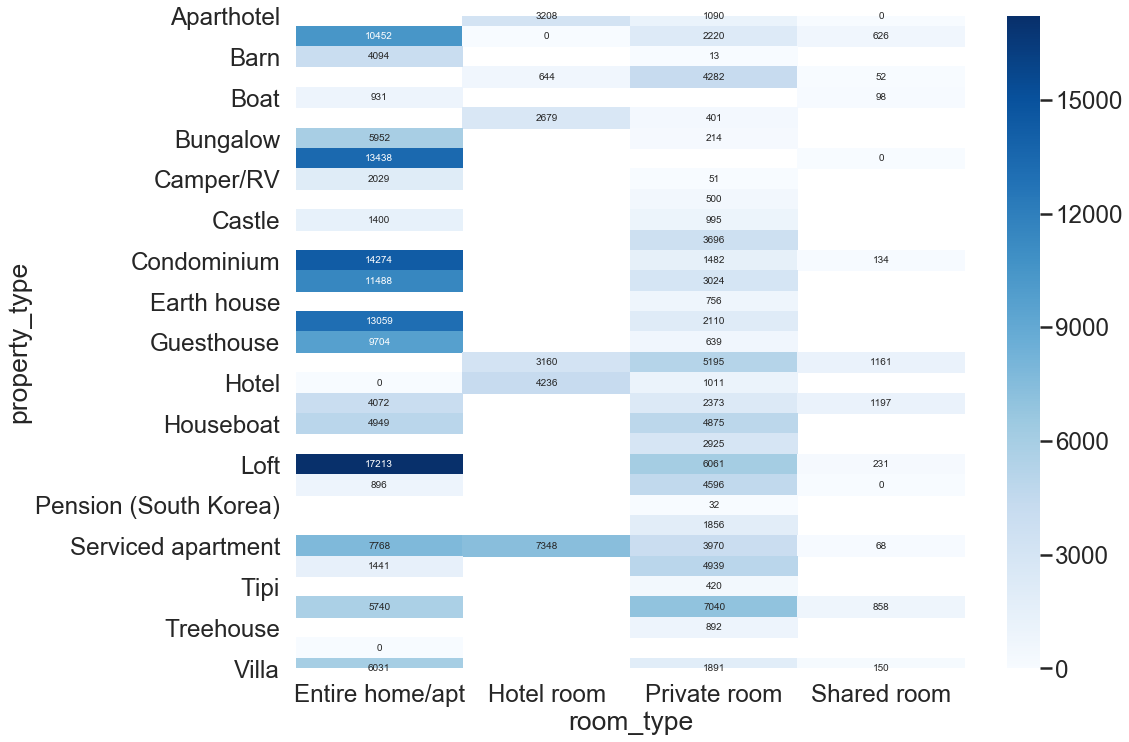

In [54]:
# heatmap of revenue vs property and room type
fig, ax = plt.subplots(figsize=(15,12));
berlin_heat = sns.heatmap(books_revenue.groupby(['property_type','room_type']).estimated_revenue.mean().unstack(),cmap="Blues",annot=True, fmt=".0f",ax=ax);
fig = berlin_heat.get_figure()
fig.savefig("./figure/berlin_prop_room_heatmap.jpg", bbox_inches='tight')

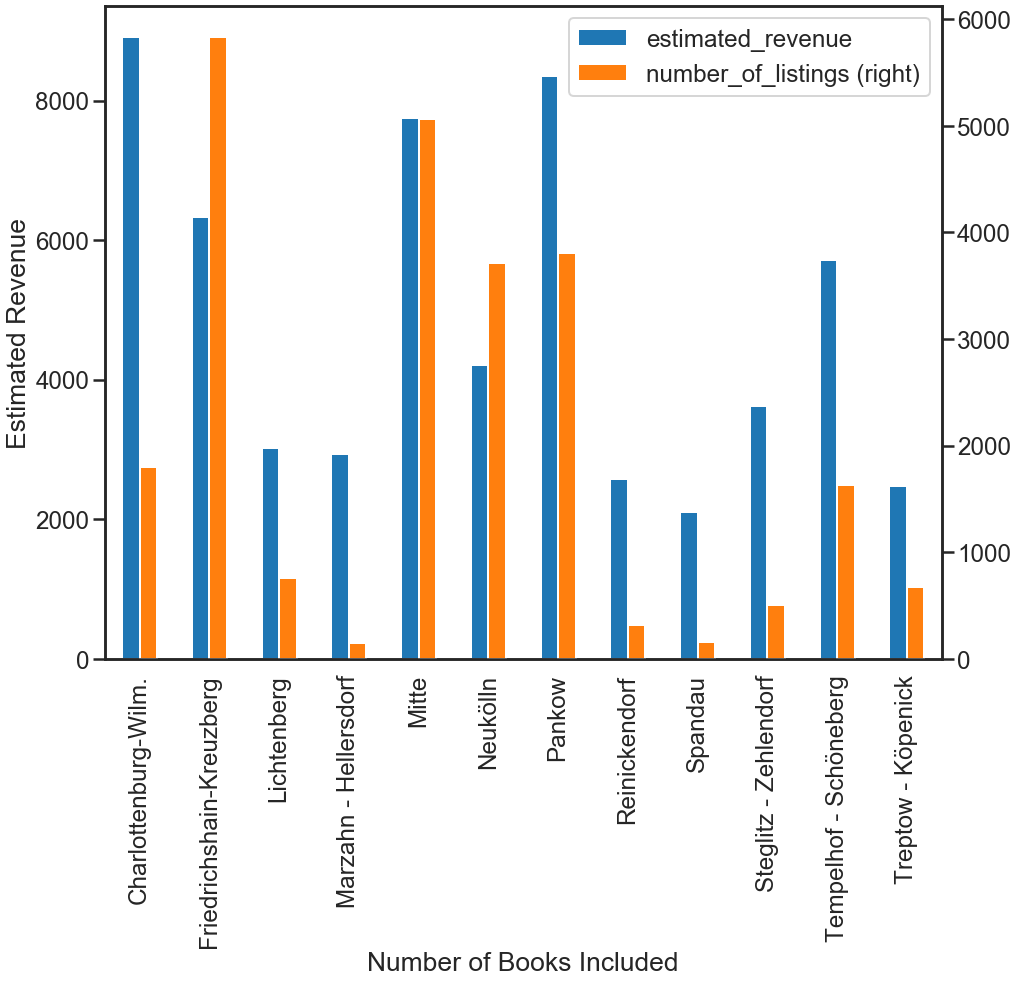

In [55]:
# Plot estimated revenues vs number of booked

books_vs_revenues = books_revenue.groupby(['neighbourhood_group_cleansed']).agg({'estimated_revenue':'mean','id':'count'})
books_vs_revenues.rename(index=str, columns={"id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(15,12))
books_vs_revenues.plot.bar(y=['estimated_revenue','number_of_listings'], secondary_y='number_of_listings', ax=ax)
ax.set_xlabel("Number of Books Included")
ax.set_ylabel("Estimated Revenue")
fig.savefig("./figure/berlin_num_books_rev_property.jpg", bbox_inches='tight')

In [56]:
# What are the most expensive district in Berlin 
mean = np.mean(books_revenue['price'])
percentile = np.percentile(books_revenue['price'], 98)
print(percentile)
y = books_revenue[(books_revenue['price'] > percentile) ][['price', 'neighbourhood_group_cleansed']]
y.shape

235.0


(484, 2)

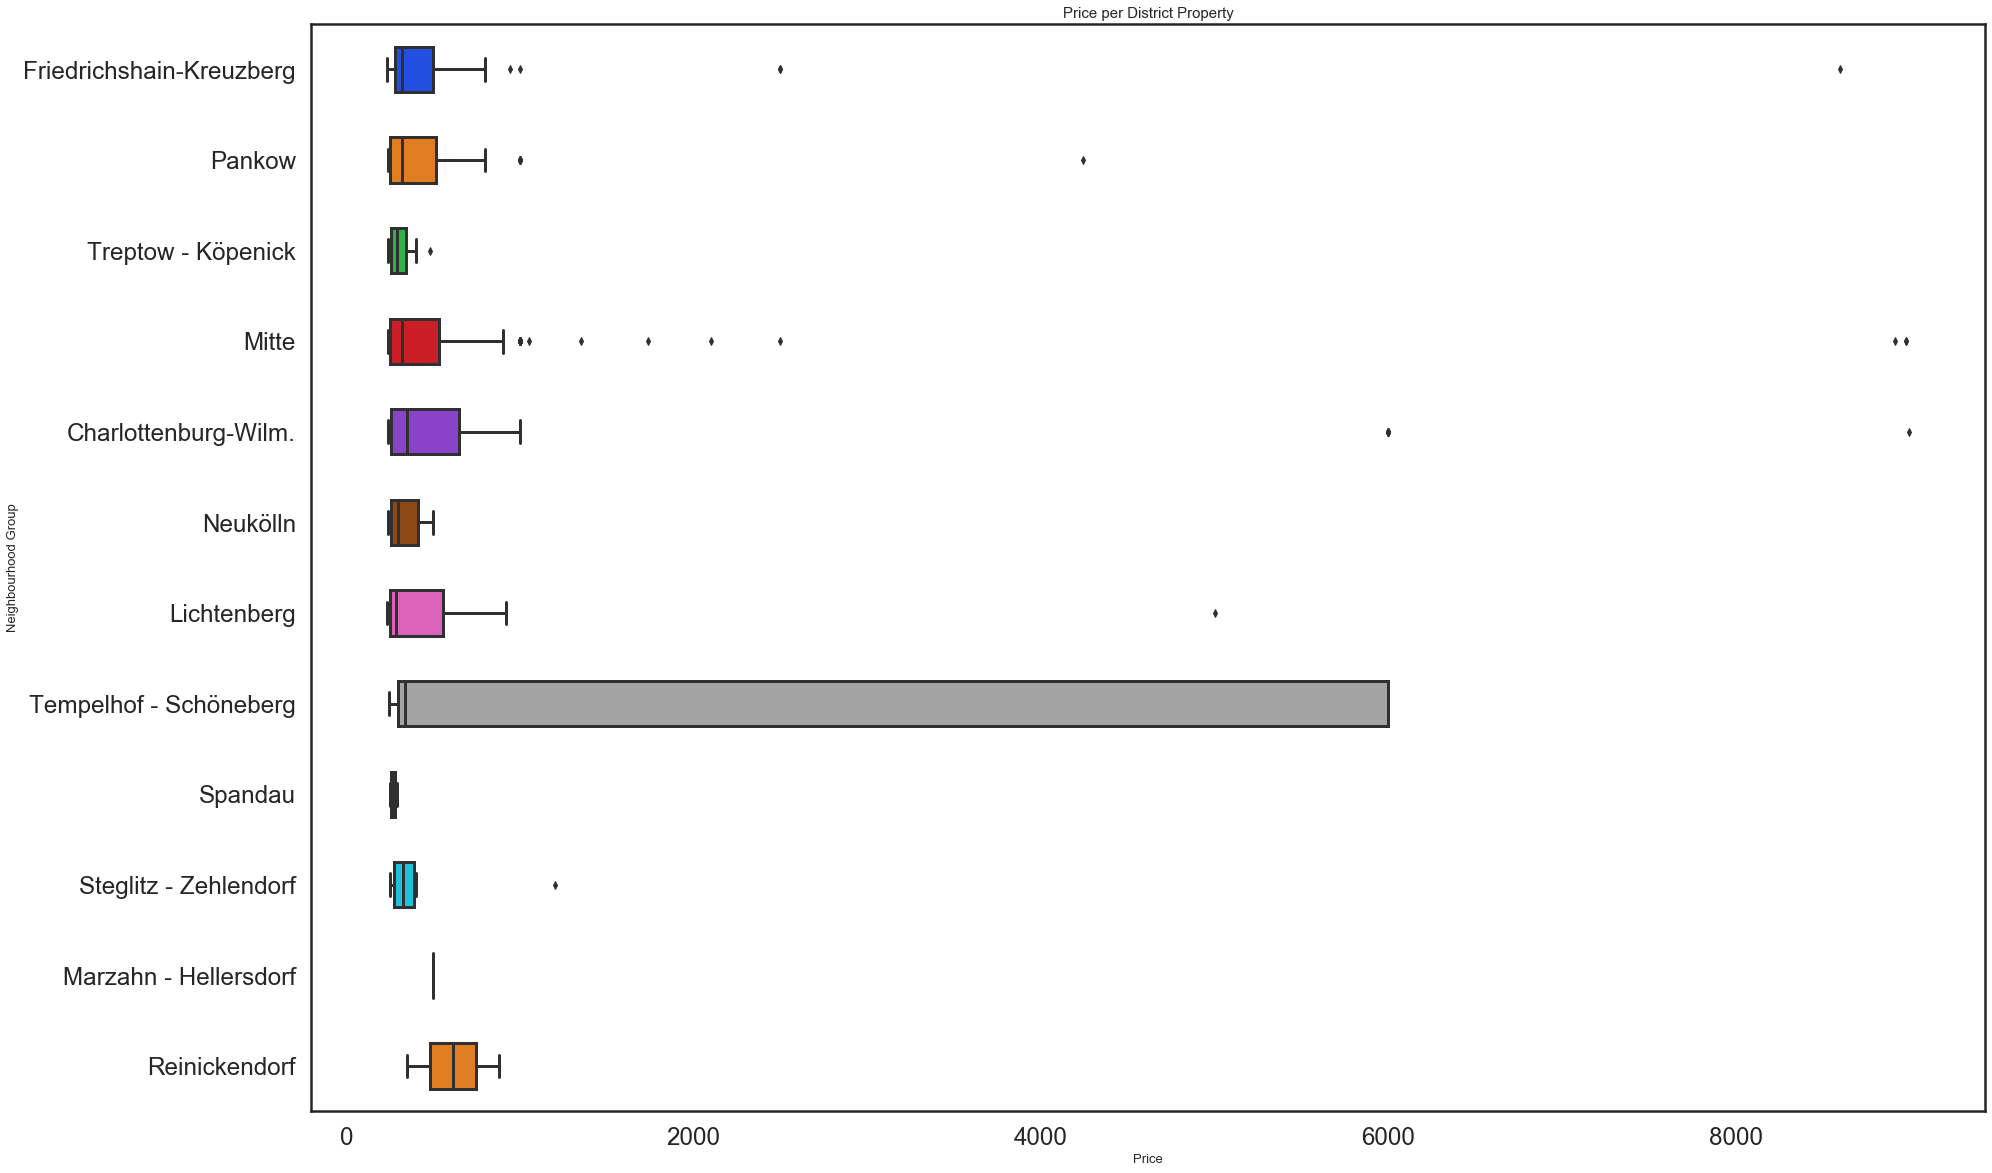

In [57]:
fig, ax = plt.subplots(figsize=(30,20))
# sns.boxenplot(y.neighbourhood_group_cleansed, y.price);
bplot = sns.boxplot(y='neighbourhood_group_cleansed',\
                    x='price',\
                    data=y,\
                    width=0.5,\
                    palette="bright",\
                    ax=ax
                   )
ax.set_title("Price per District Property", fontsize=15);
ax.set_xlabel("Price", fontsize=13);
ax.set_ylabel("Neighbourhood Group", fontsize=13);

fig.savefig("./figure/berlin_price_district_property.jpg", bbox_inches='tight')

<a id='ModelRecommend'></a>
### 7.2 Recommend what we normally want

We now proceed to model building stage . But before we start training the models we perform one last data preparation step.

We split the training data in a 80:20 ratio and use the 80 percent of the data to build the model and 20 percent of the data to validate it. While splitting we used the stratify option in the sklearn library to ensure that the data that is selected includes a representative set of the user data with the country destinations in the same proportion as the full dataset. This is very essential since the distribution of the country destination is highly unbalanced .

In [58]:
books_revenue['review_scores_rating'].describe()

count             24,422.000
mean                  95.061
std                    6.961
min                   20.000
25%                   94.000
50%                   97.000
75%                  100.000
max                  100.000
Name: review_scores_rating, dtype: float64

In [59]:
books_revenue.review_scores_rating.mean()

95.06105151093277

In [60]:
books_recommend = books_revenue.copy(deep=True)

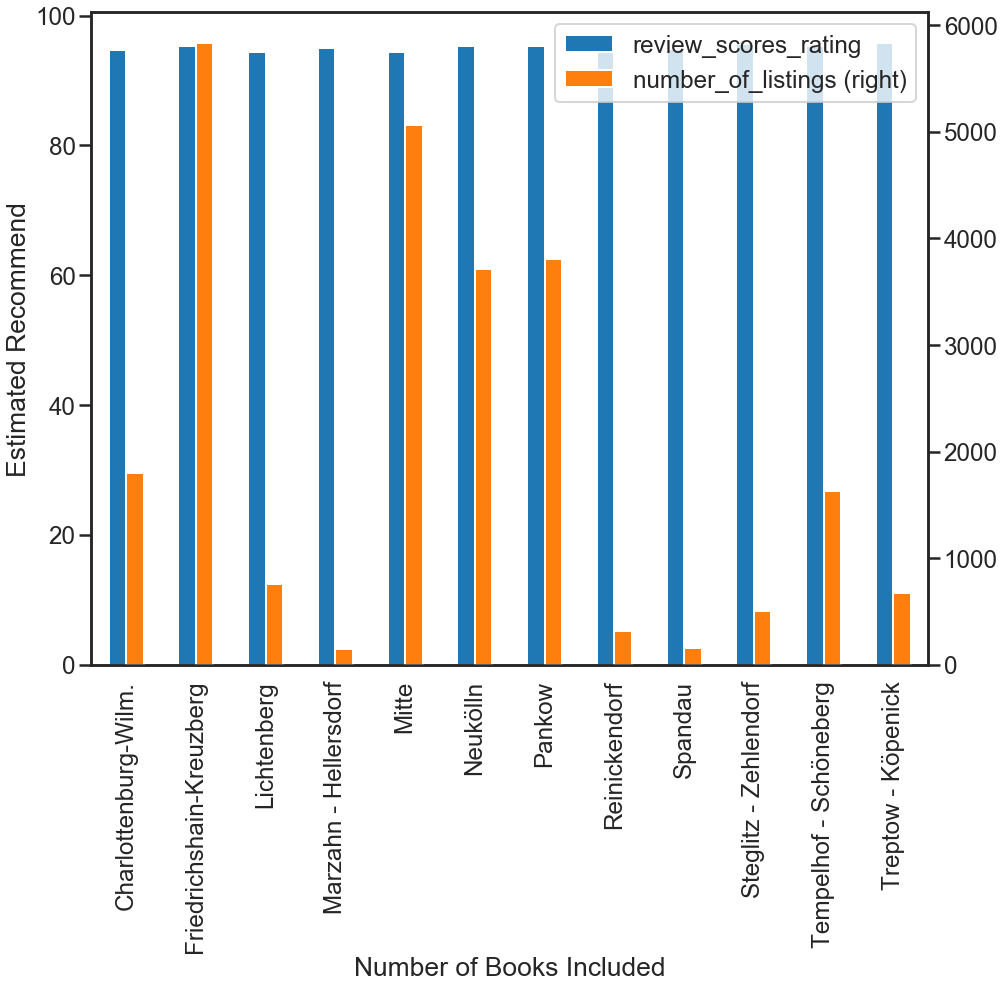

In [61]:
# Plot estimated recommend

books_recommend = books_recommend.groupby(['neighbourhood_group_cleansed']).agg({'review_scores_rating':'mean','id':'count'})
books_recommend.rename(index=str, columns={"id": "number_of_listings"},inplace=True)

fig, ax = plt.subplots(figsize=(15,12))
books_recommend.plot.bar(y=['review_scores_rating','number_of_listings'], secondary_y='number_of_listings', ax=ax)
ax.set_xlabel("Number of Books Included")
ax.set_ylabel("Estimated Recommend")
fig.savefig("./figure/berlin_num_books_recommend_property.jpg", bbox_inches='tight')

In [62]:
books_recommend

,review_scores_rating,number_of_listings
neighbourhood_group_cleansed,,
Charlottenburg-Wilm.,94.726,1798
Friedrichshain-Kreuzberg,95.249,5830
Lichtenberg,94.394,761
Marzahn - Hellersdorf,94.960,151
Mitte,94.448,5061
Neukölln,95.347,3717
Pankow,95.325,3810
Reinickendorf,95.164,318
Spandau,94.918,159


<a id='ModelEncodeRFCPCA'></a>
### 7.3 Encode it and enjoy Random Forest Classifier 

Some of these ones are pretty wild looking...  One common way to use PCA is to reduce the dimensionality of high dimensionality data that you want to use for prediction, but the results seem to be overfitting (potentially because their is a lot of noise in the data.  Which can certainly be the case with image data).

Let's take a first pass on creating a simple model to predict the values of the images using all of the data.

In [63]:
# save the data ....
books_rating = books_revenue.copy(deep=True)

In [64]:
rm_list = ['accommodates',
           'property_type',
           'room_type',
           'zipcode'
          ]

books_rating.drop(columns=rm_list,inplace=True)

In [65]:
categorical_features = ['neighbourhood_cleansed', 
                        'neighbourhood_group_cleansed'
                       ]
encode_rating = books_rating.copy(deep=True)
encode = LabelEncoder()
for j in categorical_features:
    encode_rating[j] = encode.fit_transform(books_rating[j].astype('str'))

In [66]:
summary(encode_rating)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24422 entries, 0 to 24421
Data columns (total 12 columns):
id                              24422 non-null float64
price                           24422 non-null float64
neighbourhood_cleansed          24422 non-null int32
neighbourhood_group_cleansed    24422 non-null int32
review_scores_rating            24422 non-null float64
latitude                        24422 non-null float64
longitude                       24422 non-null float64
host_id                         24422 non-null float64
minimum_nights                  24422 non-null float64
number_of_reviews               24422 non-null float64
total_days_booked               24422 non-null float64
estimated_revenue               24422 non-null float64
dtypes: float64(10), int32(2)
memory usage: 2.2 MB


Series([], dtype: float64)


no missing values
{'estimated_revenue', 'id', 'latitude', 'price', 'number_of_reviews', 'longitude', 'neighbourhood_cleansed', 'minimum_nights', 'review_

In [67]:
# Remove ID's since now we are not interested in making predictions
encode_rating.set_index('id',inplace=True)

In [68]:
# Create a new column that for each row, generates a random number between 0 and 1, and
# if that value is less than or equal to .80, then sets the value of that cell as True
# and false otherwise. This is a quick and dirty way of randomly assigning some rows to
# be used as the training data and some as the test data.
encode_rating['is_train'] = np.random.uniform(0, 1, len(encode_rating)) <= .80

In [69]:
# Create two new dataframes, one with the training rows, one with the test rows
train, test = encode_rating[encode_rating['is_train']==True], encode_rating[encode_rating['is_train']==False]

In [70]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 19569
Number of observations in the test data: 4853


In [71]:
test.sample(5)

,price,neighbourhood_cleansed,neighbourhood_group_cleansed,review_scores_rating,latitude,longitude,host_id,minimum_nights,number_of_reviews,total_days_booked,estimated_revenue,is_train
id,,,,,,,,,,,,
"20,252,911.000",26.000,104,5,100.000,52.478,13.450,"144,324,303.000",2.000,7.000,14.000,364.000,False
"13,260,257.000",41.000,93,6,90.000,52.571,13.408,"42,559,345.000",3.000,4.000,12.000,492.000,False
"4,027,819.000",55.000,97,6,90.000,52.553,13.411,"1,038,455.000",2.000,2.000,4.000,220.000,False
"30,610,294.000",57.000,106,2,97.000,52.501,13.477,"229,113,409.000",60.000,0.000,0.000,0.000,False
"3,759,884.000",30.000,121,4,97.000,52.513,13.340,"18,350,241.000",14.000,0.000,0.000,0.000,False


In [72]:
# Preprocess Data
# Create a list of the feature column's names
features = encode_rating.columns[:14]

# View features
features

Index(['price', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'review_scores_rating', 'latitude', 'longitude', 'host_id',
       'minimum_nights', 'number_of_reviews', 'total_days_booked',
       'estimated_revenue', 'is_train'],
      dtype='object')

In [73]:
X = test[~(test['neighbourhood_group_cleansed'].isnull())][features]

Y = test[~(test['neighbourhood_group_cleansed'].isnull())]['neighbourhood_group_cleansed']

X.fillna(0,inplace=True)

In [74]:
# let see the training  ... 
def fit_random_forest_classifier(X, y):
    # Set startpoint
    starttime = time.time()
    #First let's create training and testing data
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=Y)
    # I could grid search and tune, but let's just fit a simple model to see how it does
    # instantiate
    clf = RandomForestClassifier(n_estimators=100, max_depth=None)
    #fit
    clf.fit(X_train, Y_train)
    #predict
    Y_preds = clf.predict(X_test)
    # show the runtime
    runtime = time.time() - starttime    
    print('Function completed in {:.0f}m {:.0f}s'.format(runtime // 60, runtime % 60))
    # Check the score
    print ('Accuracy: ' + str(accuracy_score(Y_test, Y_preds)))
    crosstab = pd.crosstab(Y_test, Y_preds, rownames=['Actual Destrict'], colnames=['Predicted Destrict'])
    
    return clf, X_train, Y_preds, crosstab

In [75]:
clf, X_train, Y_preds, crosstab = fit_random_forest_classifier(X, Y)

Function completed in 0m 0s
Accuracy: 0.9993757802746567


In [76]:
crosstab

Predicted Destrict,0,1,2,3,4,5,6,7,8,9,10,11
Actual Destrict,,,,,,,,,,,,
0,115,0,0,0,0,0,0,0,0,0,0,0
1,0,381,0,0,0,0,0,0,0,0,0,0
2,0,0,49,1,0,0,0,0,0,0,0,0
3,0,0,0,8,0,0,0,0,0,0,0,0
4,0,0,0,0,324,0,0,0,0,0,0,0
5,0,0,0,0,0,247,0,0,0,0,0,0
6,0,0,0,0,0,0,247,0,0,0,0,0
7,0,0,0,0,0,0,0,25,0,0,0,0
8,0,0,0,0,0,0,0,0,13,0,0,0


In [77]:
importances = clf.feature_importances_

In [78]:
std = np.std([clf.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 2 (0.434381)
2. feature 5 (0.211572)
3. feature 4 (0.198171)
4. feature 1 (0.115370)
5. feature 0 (0.009356)
6. feature 6 (0.008362)
7. feature 10 (0.005689)
8. feature 8 (0.004610)
9. feature 9 (0.004602)
10. feature 3 (0.004144)
11. feature 7 (0.003744)
12. feature 11 (0.000000)


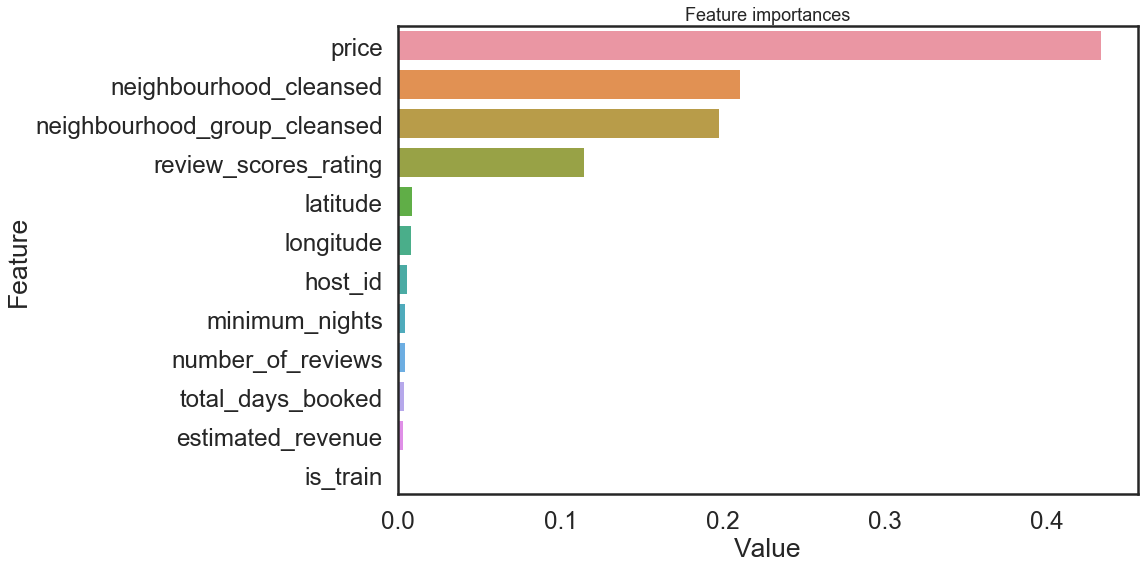

In [79]:
# Plot feature importance
feature_imp = pd.DataFrame(sorted(zip(importances[indices], X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(16, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importances', fontsize=18)
plt.tight_layout()
plt.show()
fig.savefig("./figure/berlin_randomforest.jpg", bbox_inches='tight')

The model RandomForestClassifier performs pretty well on the test set using the adjusted data. Let's see how well a model works with a smaller number of functions. Maybe it works even better by reducing the noise in the original functions.

It's worth noting that I'm not fully aware of scaling here. Even without standardization, the results are sufficient for the time being.

In [80]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    scaler = StandardScaler().fit_transform(data)
    # PCA model
    pca = PCA(n_components)
    # PCA features
    X_pca = pca.fit_transform(scaler)
    return pca, X_pca, scaler

In [81]:
pca, X_pca, scaler = do_pca(5, X)

In [82]:
clf_pca, X_train, Y_preds, crosstab = fit_random_forest_classifier(X_pca, Y)

Function completed in 0m 1s
Accuracy: 0.8533083645443196


Nice, let's look at the positives first... that was super fast. But clearly 5 components isn't giving us enough information to clearly identify the digits. Let's what can I do with this results ..

In [83]:
crosstab

Predicted Destrict,0,1,2,3,4,5,6,7,8,9,10,11
Actual Destrict,,,,,,,,,,,,
0,71,1,0,0,39,0,2,2,0,0,0,0
1,0,341,2,0,20,0,18,0,0,0,0,0
2,0,5,41,0,2,1,1,0,0,0,0,0
3,0,1,4,3,0,0,0,0,0,0,0,0
4,22,7,0,0,269,0,23,3,0,0,0,0
5,0,1,0,0,2,239,0,0,0,2,0,3
6,4,14,0,0,19,1,208,0,0,0,1,0
7,2,0,0,0,10,0,2,11,0,0,0,0
8,0,0,0,0,0,0,0,3,10,0,0,0


In [84]:
clf_pca

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

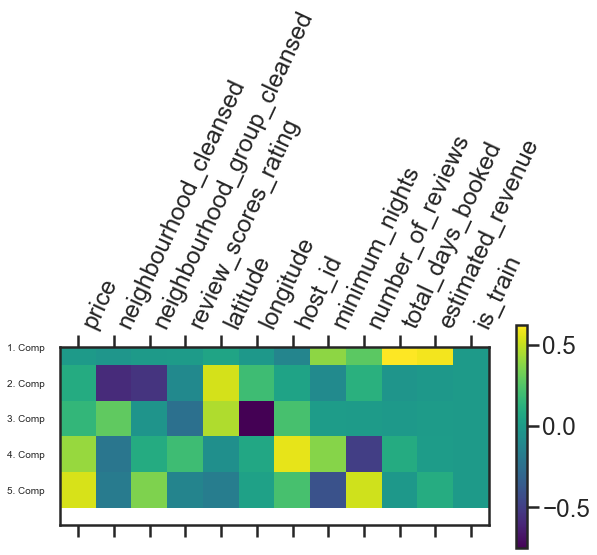

<Figure size 432x288 with 0 Axes>

In [85]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2,3,4,5],['1. Comp','2. Comp','3. Comp', '4. Comp', '5. Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(features)),features,rotation=65,ha='left')
plt.show()
plt.savefig("./figure/berlin_PCA.jpg", bbox_inches='tight')

The most interesting component seems to be cluster 5. it has the highest rating on the rating.

In [86]:
# Inverse encode data
def inverse_transform(self, dframe):
    """
    Transform labels back to original encoding.
    """
    if self.columns is not None:
        for idx, column in enumerate(self.columns):
            dframe.loc[:, column] = self.all_encoders_[idx]\
            .inverse_transform(dframe.loc[:, column].values)
    else:
        self.columns = dframe.iloc[:, :].columns
        for idx, column in enumerate(self.columns):
            dframe.loc[:, column] = self.all_encoders_[idx]\
            .inverse_transform(dframe.loc[:, column].values)
    return dframe

In [87]:
# cluster for listings respective books_rating
# k=5
# data = inverse_transform(features, clf_pca[k])
# books_rating = pd.DataFrame(data=data,
#                    index=np.array(range(0, data.shape[0])),
#                    columns=azdias.columns)
# books_rating.head()

<a id='ModelTime'></a>
### 7.4 Time trends

I would like to go back to the calendar and look at the occupancy in the last year. It should answer me when I can most likely find an apartment.

In [88]:
# routine to plot the calendar information
def date_plot(df, column, plt, title=None):
    '''
    INPUT
    df     - pandas dataframe
    column - interval variable as a string
    plt    - subplot

    OUTPUT
    X      - A date plot, with on the  x-axis the timeframe and on the y-axis the column.
    ''' 
    val = 0
    plt.plot_date(df['date'], df[column], linestyle='solid', marker='None');
    metric = locale.format_string(column, val, grouping=False);
    plt.ylabel(metric);
    if title is None:
        title = metric + ' over time'
    plt.title(title)
    
    return plt

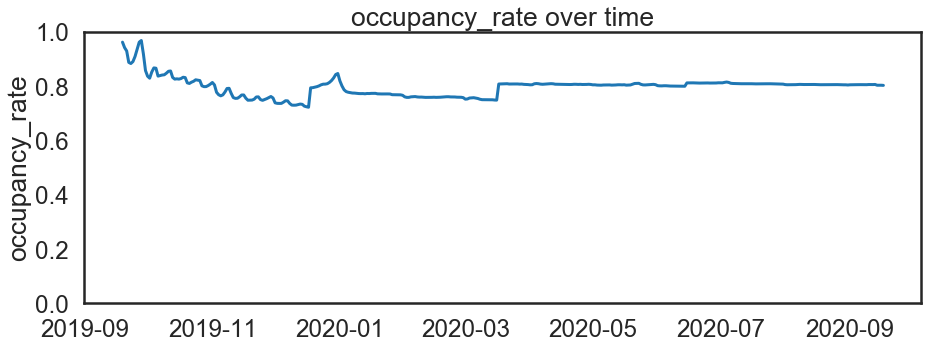

In [89]:
fig, ax = plt.subplots(figsize=(15, 5))
date_plot(clean_calendar, 'occupancy_rate', plt);
ax.set_ylim([0, 1]);
plt.savefig("./figure/berlin_timetrend.jpg", bbox_inches='tight')

<a id='Eval'></a>
## 8 Evaluation, design and show the results

Build a graph to visualize the results. This visualization should give the answer to my questions. 

<a id='EvalData'></a>
### 8.1 Nice Data in the Neighbourhood

We will be plotting a map depicting the average revenue and number of listings available in each neighbourhood. Only the top 10 neighbourhoods in terms of the number of listings available will be shown. This is to reduce the amount of clutter on the map.

Each circle represents a neighbourhood. The colour of the circle indicates the average amount of revenue generated in each neighbourhood, with higher revenues being represented by yellow and lower revenues being represented by blue. The size of the circle reflects the number of listings in the neighbourhood. The map's output will be a html file since the output of the map in the notebook will not always work as expected. Remember to close the html files before running the block of code again to generate a new map.

In [90]:
books_revenue.head()

,id,price,accommodates,property_type,room_type,neighbourhood_cleansed,neighbourhood_group_cleansed,review_scores_rating,zipcode,latitude,longitude,host_id,minimum_nights,number_of_reviews,total_days_booked,estimated_revenue
0,"1,944.000",21.000,1.000,Apartment,Private room,Brunnenstr. Nord,Mitte,82.000,13355,52.544,13.397,"2,164.000",120.000,18.000,"2,160.000","45,360.000"
1,"2,015.000",60.000,3.000,Guesthouse,Entire home/apt,Brunnenstr. Süd,Mitte,93.000,10119,52.535,13.403,"2,217.000",4.000,127.000,508.000,"30,480.000"
2,"3,176.000",90.000,4.000,Apartment,Entire home/apt,Prenzlauer Berg Südwest,Pankow,93.000,10405,52.535,13.418,"3,718.000",62.000,145.000,"8,990.000","809,100.000"
3,"3,309.000",28.000,1.000,Apartment,Private room,Schöneberg-Nord,Tempelhof - Schöneberg,89.000,10777,52.499,13.349,"4,108.000",7.000,27.000,189.000,"5,292.000"
4,"6,883.000",125.000,2.000,Loft,Entire home/apt,Frankfurter Allee Süd FK,Friedrichshain-Kreuzberg,99.000,10243,52.512,13.455,"16,149.000",3.000,126.000,378.000,"47,250.000"


In [91]:
summary(books_revenue)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24422 entries, 0 to 24421
Data columns (total 16 columns):
id                              24422 non-null float64
price                           24422 non-null float64
accommodates                    24422 non-null float64
property_type                   24422 non-null object
room_type                       24422 non-null object
neighbourhood_cleansed          24422 non-null object
neighbourhood_group_cleansed    24422 non-null object
review_scores_rating            24422 non-null float64
zipcode                         24422 non-null object
latitude                        24422 non-null float64
longitude                       24422 non-null float64
host_id                         24422 non-null float64
minimum_nights                  24422 non-null float64
number_of_reviews               24422 non-null float64
total_days_booked               24422 non-null float64
estimated_revenue               24422 non-null float64
dtypes: float64(

In [92]:
# aggregate the neighbourhood with the estimated revenue
books_vs_neighb = books_revenue.groupby(['neighbourhood_cleansed']).agg({'estimated_revenue':'mean',
                                                                         'latitude': 'mean',
                                                                         'longitude': 'mean',
                                                                         'id':'count',
                                                                         'review_scores_rating': 'mean',
                                                                         'neighbourhood_group_cleansed': 'first'
                                                                        })
books_vs_neighb.rename(index=str, columns={"id": "number_of_listings"},inplace=True)
# get only top 10 neighbourhoods in terms of number of listings
books_vs_neighb = books_vs_neighb.sort_values(by=['number_of_listings'], ascending=False).head(10)

In [93]:
books_vs_neighb.head()

,estimated_revenue,latitude,longitude,number_of_listings,review_scores_rating,neighbourhood_group_cleansed
neighbourhood_cleansed,,,,,,
Frankfurter Allee Süd FK,"3,744.777",52.508,13.462,1446,95.171,Friedrichshain-Kreuzberg
Tempelhofer Vorstadt,"8,948.758",52.491,13.400,1363,95.406,Friedrichshain-Kreuzberg
Alexanderplatz,"12,093.493",52.522,13.404,1247,94.423,Mitte
Reuterstraße,"5,238.581",52.487,13.433,1063,95.528,Neukölln
Rixdorf,"2,981.733",52.478,13.446,921,94.982,Neukölln


In [94]:
#Reset the index to 1 level to fill in year
books_vs_neighb = books_vs_neighb.set_axis(books_vs_neighb.columns.map(''.join), axis=1, inplace=False)
# books_vs_neighb = books_vs_neighb.reset_index(level=[0,1])
books_vs_neighb = books_vs_neighb.reset_index()


# Rename neighbourhood_cleansed to neighbourhood
books_vs_neighb = books_vs_neighb.rename(columns={'neighbourhood_cleansed': 'neighbourhood'})
# books_vs_neighb = books_vs_neighb.rename(columns={'neighbourhood_group_cleansed': 'neighbourhood_group'})

In [95]:
books_vs_neighb.head()

,neighbourhood,estimated_revenue,latitude,longitude,number_of_listings,review_scores_rating,neighbourhood_group_cleansed
0,Frankfurter Allee Süd FK,"3,744.777",52.508,13.462,1446,95.171,Friedrichshain-Kreuzberg
1,Tempelhofer Vorstadt,"8,948.758",52.491,13.400,1363,95.406,Friedrichshain-Kreuzberg
2,Alexanderplatz,"12,093.493",52.522,13.404,1247,94.423,Mitte
3,Reuterstraße,"5,238.581",52.487,13.433,1063,95.528,Neukölln
4,Rixdorf,"2,981.733",52.478,13.446,921,94.982,Neukölln


<a id='EvalGoogle'></a>
### 8.2 A picture can help 

We will be plotting a map depicting the average revenue and number of listings available in each neighbourhood. 

Each colored range represents a neighbourhood. The colour of the range indicates the average amount of revenue generated in each neighbourhood, with higher revenues being represented by dark blue and lower revenues being represented thru white. The size of the circle reflects the number of listings in the neighbourhood. The map's output will be a interactive html file since the output of the map in the notebook will not always work as expected. Remember to close the html files before running the block of code again to generate a new map.

In [96]:
# Reading in google maps api key. Required for bokeh gmaps
# For GMaps to function, Google requires you obtain and enable an API key:
#
#     https://developers.google.com/maps/documentation/javascript/get-api-key
#
file = open("my_api_key.txt","r")
MY_API_KEY = file.read()

# Replace with your own google map api
# MY_API_KEY = ""

In [97]:
# GeoInformation from Berlin
crs = 'EPSG:3068' 
xmin = 13.0800
ymin = 52.3300
xmax = 13.7700
ymax = 52.6800

x_range = Range1d(start=xmin, end=xmax, bounds=None)
y_range = Range1d(start=ymin, end=ymax, bounds=None)

output_file("./figure/berlin_revenue.html")

In [98]:
# Set the Coordinate Referance System (crs) for projections
# ESPG code 3068 für Berlin
nbhgeos.crs = {'init': 'epsg:3068'}

nbhgeos.sort_values(by=['neighbourhood'])
nbhgeos.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


In [99]:
# Create colorbar formatting lookup table
# This dictionary contains the formatting for the data in the plots
format_data = [('estimated_revenue', 0, 10000000,'€0.0', 'Estimated Revenue'),
               ('number_of_listings', 0, 500000,'0.0', 'Number of Listings'),
               ('review_scores_rating', 0, 500000,'0.0', 'Scores Rating'),
              ]
 
#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])
format_df.head(10)

,field,min_range,max_range,format,verbage
0,estimated_revenue,0,10000000,€0.0,Estimated Revenue
1,number_of_listings,0,500000,0.0,Number of Listings
2,review_scores_rating,0,500000,0.0,Scores Rating


In [136]:
# Create a function the returns json_data for the year selected by the user
def json_data(selectedData):
    sd = selectedData
    
    # Pull selected year from neighborhood summary data
    # df_sd = books_vs_neighb[books_vs_neighb['component'] == sd]
    
    # Merge the GeoDataframe object (nbhgeos) with the neighborhood summary data (books_vs_neighb)
    # merged = pd.merge(districts, books_vs_neighb, left_on='neighbourhood', right_on='neighbourhood')
    merged = pd.merge(districts, books_vs_neighb, left_on='neighbourhood', right_on='neighbourhood', how='left')
    # Rename neighbourhood_cleansed to neighborhood
    merged = merged.rename(columns={'neighbourhood_group_x': 'neighbourhood_group'})
    
    # Fill the null values
    values = {'estimated_revenue': 0, 
              'number_of_listings': 0, 
              'review_scores_rating': 0}
    merged = merged.fillna(value=values)
    
    # Bokeh uses geojson formatting, representing geographical features, with json
    # Convert to json
    merged_json = json.loads(merged.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

In [137]:
# Define the callback function: update_plot
def update_plot(attr, old, new):
    # The input yr is the year selected from the slider
    cluster = slider.value
    new_data = json_data(cluster)
    
    # The input cr is the criteria selected from the select box
    cluster_box = select.value
    input_field = format_df.loc[format_df['verbage'] == cluster_box, 'field'].iloc[0]
    
    # Update the plot based on the changed inputs
    p = make_plot(input_field)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(select), widgetbox(slider))
    curdoc().clear()
    curdoc().add_root(layout)
    
    # Update the data
    geosource.geojson = new_data 

In [138]:
# Create a plotting function
def make_plot(field_name):
    # Define a sequential multi-hue color palette.
    palette = brewer['Blues'][8]

    # Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]
  
    # Set the format of the colorbar
    min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
    max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
    field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]

    # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)

    # Create color bar.
    format_tick = NumeralTickFormatter(format=field_format)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, formatter=format_tick,
    border_line_color=None, location = (0, 0))

    # Create figure object.
    verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]

    p = figure(title = verbage + ' by Neighborhood', 
             plot_height = 650, plot_width = 850,
             toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = False

    # Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
  
    # Specify color bar layout.
    p.add_layout(color_bar, 'right')

    # Add the hover tool to the graph
    p.add_tools(hover)
    return p, color_bar

In [139]:
# Hint: The districts are saved as MULTIPOLYGON. So I dissolved this ..
districts = nbhgeos.dissolve(by='neighbourhood')

In [140]:
districts = districts.reset_index()

In [141]:
nbhgeos.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


In [142]:
districts.head()

,neighbourhood,geometry,neighbourhood_group
0,Adlershof,"POLYGON ((13.55429 52.42581, 13.55424 52.42580...",Treptow - Köpenick
1,Albrechtstr.,"POLYGON ((13.32681 52.46139, 13.32700 52.46160...",Steglitz - Zehlendorf
2,Alexanderplatz,"POLYGON ((13.40559 52.52967, 13.40721 52.52939...",Mitte
3,Allende-Viertel,"POLYGON ((13.58666 52.44096, 13.58587 52.44132...",Treptow - Köpenick
4,Alt Treptow,"POLYGON ((13.43966 52.48991, 13.43967 52.49014...",Treptow - Köpenick


In [143]:
summary(districts)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 3 columns):
neighbourhood          138 non-null object
geometry               138 non-null geometry
neighbourhood_group    138 non-null object
dtypes: geometry(1), object(2)
memory usage: 3.3+ KB


Series([], dtype: float64)


no missing values
{'geometry', 'neighbourhood_group', 'neighbourhood'}


most missing values
set()


In [144]:
    # Merge the GeoDataframe object (nbhgeos) with the neighborhood summary data (books_vs_neighb)
    merged = pd.merge(districts, books_vs_neighb, left_on='neighbourhood', right_on='neighbourhood', how='left')
    # Rename neighbourhood_cleansed to neighborhood
    merged = merged.rename(columns={'neighbourhood_group_x': 'neighbourhood_group'})

In [145]:
summary(merged)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 9 columns):
neighbourhood                   138 non-null object
geometry                        138 non-null geometry
neighbourhood_group             138 non-null object
estimated_revenue               10 non-null float64
latitude                        10 non-null float64
longitude                       10 non-null float64
number_of_listings              10 non-null float64
review_scores_rating            10 non-null float64
neighbourhood_group_cleansed    10 non-null object
dtypes: float64(5), geometry(1), object(3)
memory usage: 10.8+ KB


estimated_revenue                            92.754
latitude                                     92.754
longitude                                    92.754
number_of_listings                           92.754
review_scores_rating                         92.754
neighbourhood_group_cleansed                 92.754
dtype: float64


no missing values
{'ge

In [146]:
# get the married dates from geoinformation berlin and the analyzed data 
geosource = GeoJSONDataSource(geojson = json_data(all))

In [148]:
# Control field for the interactive information
input_field = 'estimated_revenue'

# Add hover tool
hover = HoverTool(tooltips = [ ('Neighborhood','@neighbourhood'),
                               ('Neighborhood Group','@neighbourhood_group'),
                               ('Estimated Revenue', '€@estimated_revenue'),
                               ('Number of Listings', '@number_of_listings{,}'),
                               ('Scores Rating', '@review_scores_rating{,}')
                             ])

# Call the plotting function
pic, color_bar = make_plot(input_field)

# Make a slider object: slider 
# slider = Slider(title = 'Year',start = 2009, end = 2018, step = 1, value = 2018)
# slider.on_change('value', update_plot)

# Make a selection object: select
# select = Select(title='Select Criteria:', value='Estimated Revenue', options=['Estimated Revenue', 'Number of Listings',
#                                                                                'Scores Rating'])
# select.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
# layout = column(p, widgetbox(select), widgetbox(slider))
# curdoc().add_root(layout)

# Use the following code to test in a notebook
# Interactive features will no show in notebook
output_notebook()
show(pic)

Loading BokehJS ...

<a id='EvalConclusion'></a>
### 8.3 Conclusion 

Finally, I would like to reiterate my questions:

#### What is the booking load

In the chapter "5.5 Neighborhouds", "5.6 Neighborhouds GeoInformation" and "7.1 Build models to predict listing quotations" on it received and looked for the answer.

#### How is the district scoring?

A good visualization of this question can be found in the chapter "7.2 Recommend what we normally want" as an answer.

#### What are the revenues of the district?

Somewhat more extensive was the income expected in the chapter "7.1 Build models to predict listing revenues".

#### Show me the best place to live

After modeling the data with the RandomFirestClassifier and PCA, we again ask for the best place to live and give the answer in a Google Maps as a depletion.

<a id='Deploy'></a>
## 9 Deployment

Key findings from this analysis are used in a [blog post](https://https://medium.com/p/e0a70f3534ac/). 
This analysis can found [here](https://github.com/gerald-e/WADSBP_AirBnB)

In [106]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook AirBnB accomondation.ipynb to html',
 '[NbConvertApp] Writing 454984 bytes to AirBnB accomondation.html',
 '[NbConvertApp] Converting notebook AirBnB_Google.ipynb to html',
 '[NbConvertApp] Writing 2502658 bytes to AirBnB_Google.html']

In [107]:
!pip freeze > requirements.txt